In [1]:
import os
import sys
import re
import importlib
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import torch.nn as nn

from pathlib import Path
from torch.utils.data import DataLoader

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
module_path = os.path.abspath(os.path.join('../../deeplearner'))
sys.path.insert(0, module_path)

In [3]:
from deeplearner.datatorch import *
from deeplearner.utils import *
from deeplearner.compiler import *
from deeplearner.losses import *
from deeplearner.models.unet_att_d import unet_att_d

In [4]:
make_reproducible(seed=42)

In [5]:
yaml_config_path = "/home/airg/skhallaghi/deeplearner_normalization_test/deeplearner/config/default_config_ex2.yaml"

with open(yaml_config_path, "r") as cfg:
    config = yaml.load(cfg, Loader=yaml.SafeLoader)

In [6]:
# import pprint
# pprint.pprint(config, width=100, compact=True)

In [7]:
exclude_tiles_list = ["imagery/planet/tiles/2022/tile66177601_2022-03_buf179_cog.tif",
                      "imagery/planet/tiles/2022/tile680962_2022-09_buf179_cog.tif",
                      "imagery/planet/chips/v2/GH0765161_3261_6462_os.tif",
                      "imagery/planet/chips/v2/GH0769863_2971_6476_os.tif"]

In [8]:
train_catalog = pd.read_csv(Path(config["source_dir"]) / config["train_csv_name"]).reset_index(drop=True)

# name_filter = ["drop", ("NG")]  # drop or keep names beginning with

# if name_filter:
#     if name_filter[0] == "drop":
#         train_catalog = train_catalog[~train_catalog.name.str.startswith(name_filter[1])]\
#             .reset_index(drop=True)
#     else: 
#         train_catalog = train_catalog[catalog.name.str.startswith(name_filter[1])]\
#             .reset_index(drop=True)

train_catalog = train_catalog[~train_catalog['dir_os'].isin(exclude_tiles_list)].reset_index(drop=True)

In [9]:
#train_catalog = train_catalog.head(300)
print(f"catalog shape: {train_catalog.shape}")
train_catalog.head()

catalog shape: (4977, 9)


,name,dir_label,label_group,dir_gs,dir_os,usage,year,tile,class
0,GH0635115,labels/GH0635115_3180_6263.tif,0,images/gs/GH0635115_3180_6263_gs.tif,images/os/GH0635115_3180_6263_os.tif,train,2018,NaN,NaN
1,GH0644758,labels/GH0644758_3589_6274.tif,0,images/gs/GH0644758_3589_6274_gs.tif,images/os/GH0644758_3589_6274_os.tif,train,2018,NaN,NaN
2,GH0325194,labels/GH0325194_3133_5833.tif,0,images/gs/GH0325194_3133_5833_gs.tif,images/os/GH0325194_3133_5833_os.tif,train,2018,NaN,NaN
3,GH0572047,labels/GH0572047_3005_6185.tif,0,images/gs/GH0572047_3005_6185_gs.tif,images/os/GH0572047_3005_6185_os.tif,train,2018,NaN,NaN
4,GH0460427,labels/GH0460427_3505_6034.tif,0,images/gs/GH0460427_3505_6034_gs.tif,images/os/GH0460427_3505_6034_os.tif,train,2018,NaN,NaN


## Training Phase

### Train/val loader

In [10]:
train_dataset = planetData(dataPath=config["source_dir"],
                           log_dir=config["log_dir"], 
                           catalog=train_catalog,
                           dataSize=config["patch_size"], 
                           buffer=config["one_side_buffer"],
                           bufferComp=config["tile_buffer"],  
                           usage="train",
                           norm_stats_type=config["norm_stats_type"],
                           clip_val=config["clip_val"],
                           global_stats=config["global_stats"], 
                           nodata_val_ls=config["nodata"],
                           imgPathCols=config["img_path_cols"], 
                           labelPathCol=config["label_path_col"], 
                           labelGroup=config["train_group"], 
                           deRotate=config["rotationDegree"], 
                           bShiftSubs=config["bshift_band_grouping"], 
                           trans=config["transformations"])

----------4781 samples loaded in train dataset-----------


In [ ]:
# def check_images_for_zeros_and_nans(train_dataset):
#     # Initialize a dictionary to hold the count of zeros and NaNs for each image
#     img_report = {}

#     # Iterate through the dataset
#     for index, (img, lbl, mask) in enumerate(train_dataset):
#         # Count the number of zeros in the image
#         zeros_count = np.count_nonzero(img == 0)
        
#         # Count the number of NaNs in the image
#         nans_count = np.count_nonzero(np.isnan(img))
        
#         # Store the counts in the report dictionary with the image index as the key
#         img_report[index] = {'zeros': zeros_count, 'nans': nans_count}

#         # Optionally, you can print out the report for each image
#         print(f"Image {index}: Zeros = {zeros_count}, NaNs = {nans_count}")

#     return img_report

# check_images_for_zeros_and_nans(train_dataset)

In [11]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=config["train_batch"], 
                              shuffle=True)

In [12]:
validation_dataset = planetData(dataPath=config["source_dir"],
                                log_dir=config["log_dir"],
                                catalog=train_catalog, 
                                dataSize=config["patch_size"], 
                                buffer = config["one_side_buffer"],
                                bufferComp = config["tile_buffer"],
                                usage = "validate",
                                norm_stats_type=config["norm_stats_type"],
                                clip_val=config["clip_val"],
                                global_stats=config["global_stats"], 
                                nodata_val_ls=config["nodata"],
                                imgPathCols = config["img_path_cols"],
                                labelPathCol = config["label_path_col"], 
                                labelGroup=config["validate_group"])

----------196 samples loaded in validate dataset-----------


In [13]:
validation_dataloader = DataLoader(validation_dataset, 
                                 batch_size=config["validate_batch"], 
                                 shuffle=False)

In [14]:
#images, labels = next(iter(validation_dataloader))

In [6]:
model = unet_att_d(n_classes=config["n_classes"],
                   in_channels=config["channels"],
                   filter_config=config["stage_width"],
                   block_num=config["block_num"],
                   dropout_rate=config["train_dropout_rate"],
                   dropout_type=config["dropout_type"],
                  use_skipAtt=False,)

In [7]:
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               buffer = config["one_side_buffer"],
                               class_mapping=config["class_mapping"],
                               gpuDevices = config["gpu_devices"], 
                               params_init = config["params_init_path"],
                               freeze_params = config["freeze_layer_ls"])

---------- Pre-trained model compiled successfully ----------
----------GPU available----------
total number of trainable parameters: 157.9M


In [17]:
criterion_name = config['criterion']['name']
weight = config['criterion']['weight']
ignore_index = config['criterion']['ignore_index']
gamma = config['criterion']['gamma']
alpha = config['criterion']['alpha']

if criterion_name == 'TverskyFocalLoss':
    criterion = TverskyFocalLoss(weight=weight, ignore_index=ignore_index, alpha=alpha, gamma=gamma)
elif criterion_name == "LocallyWeightedTverskyFocalLoss":
    criterion = LocallyWeightedTverskyFocalLoss(ignore_index=ignore_index, alpha=alpha, gamma=gamma)
elif criterion_name == "LocallyWeightedTverskyFocalCELoss":
    criterion = LocallyWeightedTverskyFocalCELoss(ignore_index=ignore_index, tversky_alpha=alpha, 
                                                  tversky_gamma=gamma)
elif criterion_name == 'BalancedCE':
    criterion = BalancedCrossEntropyLoss(ignore_index=ignore_index)
else:
    raise ValueError("Invalid 'criterion_name'.")

In [18]:
compiled_model.fit(train_dataloader, 
                   validation_dataloader, 
                   epochs = config["epochs"],
                   optimizer_name = config["optimizer"],
                   lr_init = config["learnrate_init"],
                   lr_policy = config["LR_policy"],
                   criterion = criterion,
                   momentum = config["momentum"],
                   resume = config["resume"],
                   resume_epoch = config["resume_epoch"],
                   **config["fitting_prams"])

-------------------------- Start training --------------------------
[1/120]
Using SGD
train loss:1.0658065708478293
validation loss: 1.1253635944152365
LR: 0.014911281229302152
time: 144
[2/120]
Using SGD
train loss:1.0537256983915966
validation loss: 1.0763736041832943
LR: 0.014911281229302152
time: 137
[3/120]
Using SGD
train loss:1.0511691510677337
validation loss: 1.0961114788541988
LR: 0.014822277119245861
time: 136
[4/120]
Using SGD
train loss:1.0402893320719402
validation loss: 1.0616841732847446
LR: 0.014732984097201645
time: 138
[5/120]
Using SGD
train loss:1.0180893989404043
validation loss: 1.0400193406611073
LR: 0.014643398511944045
time: 136
[6/120]
Using SGD
train loss:0.9963438447316487
validation loss: 1.0165614087362678
LR: 0.01455351663116347
time: 136
[7/120]
Using SGD
train loss:0.976081604162852
validation loss: 0.9704368222428827
LR: 0.014463334638874763
time: 137
[8/120]
Using SGD
train loss:0.9692457600434621
validation loss: 0.9865834244659969
LR: 0.0143728486

In [ ]:
compiled_model.save(save_object="params")

--------------------- Model parameters is saved to disk ---------------------


---------------- Start evaluation ----------------


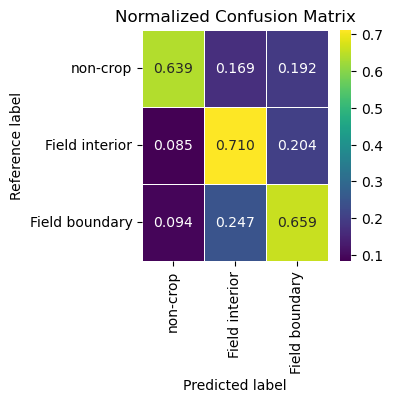

--------- Evaluation finished in 2s ---------


In [ ]:
metrics = compiled_model.accuracy_evaluation(validation_dataloader, unknown_class_idx=None, filename=config["val_metric_fname"])

## Prediction Phase

In [8]:
catalog = pd.read_csv(Path(config["pred_data_dir"]) / config["pred_csv_name"], index_col=0)
tile_count = len(catalog)

In [9]:
print(f"catalog shape: {catalog.shape}")
catalog.head()

catalog shape: (20, 7)


,tile,tile_col,tile_row,aoi,image_dir,label_dir,type
0,487103,310,543,1,tile487103_2018-12_composite.tif,lbl_487103_2018.tif,center
1,487103,310,543,1,tile487103_2019-06_2019-11_buf179_cog.tif,lbl_487103_2019.tif,center
2,487103,310,543,1,tile487103_2020-11_buf179_cog.tif,lbl_487103_2020.tif,center
3,487103,310,543,1,tile487103_2021-11_buf179_cog.tif,lbl_487103_2021.tif,center
4,487103,310,543,1,tile487103_2022-11_buf179_cog.tif,lbl_487103_2022.tif,center


In [10]:
def load_prediction_data(usage, catalog_row):
    dataset = planetData(dataPath=config["pred_data_dir"],
                         log_dir=config["log_dir"],
                         catalog=catalog, 
                         dataSize=config["pred_patch_size"], 
                         buffer=config["pred_buffer"], 
                         bufferComp=config["pred_composite_buffer"], 
                         usage=usage,
                         norm_stats_type=config["norm_stats_type"],
                         clip_val=config["clip_val"],
                         global_stats=config["global_stats"], 
                         nodata_val_ls=config["nodata"],
                         imgPathCols=config["pred_img_path_cols"],
                         catalogIndex=catalog_row)
    data_loader = DataLoader(dataset, batch_size=config["pred_batch"], shuffle=False)
    meta = dataset.meta
    tile = dataset.tile
    year = dataset.year
    return data_loader, meta, tile, year

In [11]:
for i in range(tile_count):
    pred_data = load_prediction_data("predict", i)
    compiled_model.predict(pred_data, outPrefix=config["output_prefix"], predBuffer=config["pred_buffer"],
                           mc_samples=config["num_mc_trials"], shrinkBuffer=config["shrink_buffer"], 
                           hardening_threshold=config["hardening_threshold"])

-------------------------- Start prediction --------------------------
-------------------------- Prediction finished in 96s --------------------------
-------------------------- Start prediction --------------------------
-------------------------- Prediction finished in 91s --------------------------
-------------------------- Start prediction --------------------------
-------------------------- Prediction finished in 92s --------------------------
-------------------------- Start prediction --------------------------
-------------------------- Prediction finished in 91s --------------------------
-------------------------- Start prediction --------------------------
-------------------------- Prediction finished in 91s --------------------------
-------------------------- Start prediction --------------------------
-------------------------- Prediction finished in 91s --------------------------
-------------------------- Start prediction --------------------------
-----------------